In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from numpy import *
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate
import opstrat as op
pd.set_option('display.max_rows', 300)

# Black-Scholes Model

In [2]:
class BS:

    """
    Class for European Options contract pricing on stocks without dividends.
    
    Parameters: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in units years]
        volatility    : float
    """

    def __init__(self, spot, strike, rate, dte, volatility):
        
        ''' ======= Define Parameters ======= '''
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.dte = dte
        self.volatility = volatility

        ''' ====== define d1, d2, and discount factor b ====== '''
        # Note: we'll just use norm.cdf for the function N(x)
        
        self._a_ = self.volatility * self.dte**0.5

        if self.strike == 0:
            raise ZeroDivisionError("Strike price can't be zero")
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                         (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_

        self._d2_ = self._d1_ - self._a_
        self._b_ = e**-(self.rate * self.dte)

        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', 'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None

        [self.callPrice, self.putPrice] = self._price
        [self.callDelta, self.putDelta] = self._delta
        [self.callTheta, self.putTheta] = self._theta
        [self.callRho, self.putRho] = self._rho
        self.vega = self._vega
        self.gamma = self._gamma


    # Option Price    
    @property
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            # call = S * N(d1) - K * e^(-rt) * N(d2)
            call = (self.spot * norm.cdf(self._d1_) 
                    - self.strike * e**(-self.rate * self.dte) * norm.cdf(self._d2_))
            # put = K * e^(-rt) * N(-d2) - S * N(-d1)
            put = (self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) 
                   - self.spot * norm.cdf(-self._d1_))
        return [call, put]


    # Option Delta
    @property
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]


    # Option Gamma
    @property
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)


    # Option Vega
    @property
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100


    # Option Theta
    @property
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]


    # Option Rho
    @property
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]

    # Implied Vol
    @property
    def _IV(self):
        pass

# Explore Basic Option Pricing

### Define Parameters

In [3]:
# define our parameters
S = 521
E = 521
spots = arange(S*0.25, S*1.75, 1)
r = 0.05
T = 1
t = 0
sigma = 0.2

### Example Option

In [4]:
# initialize option
option = BS(S, E, r, (T-t), sigma)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table,header))

  Option Price     Delta       Gamma       Theta    Vega      Rho
--------------  --------  ----------  ----------  ------  -------
       54.4475  0.636831  0.00360115  -0.0915537   1.955  2.77341


### Option Price vs. Spot Price

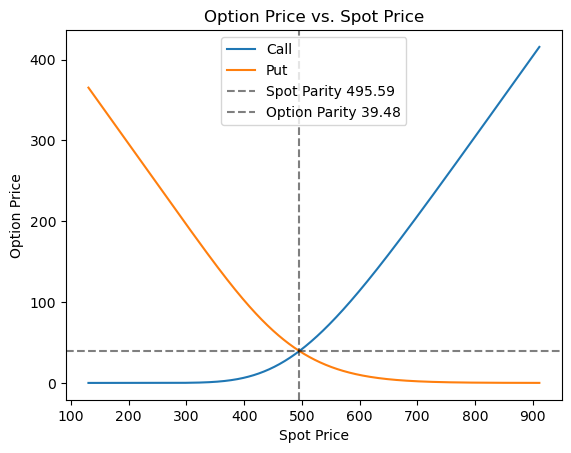

In [5]:
calls = [BS(s, E, r, (T-t), sigma).callPrice for s in spots]
puts = [BS(s, E, r, (T-t), sigma).putPrice for s in spots]

# C - P = S - Ee^(-r(T-t))
spot_parity = E*e**(-r*(T-t))
call_value_parity = BS(spot_parity, E, r, (T-t), sigma).callPrice
put_value_parity = BS(spot_parity, E, r, (T-t), sigma).putPrice

assert np.isclose(call_value_parity, put_value_parity)

plt.plot(spots, calls, label='Call')
plt.plot(spots, puts, label='Put')
plt.axvline(x=spot_parity, color='black', linestyle='--', label=f'Spot Parity {spot_parity:.2f}', alpha=0.5)
plt.axhline(y=call_value_parity, color='black', linestyle='--', label=f'Option Parity {call_value_parity:.2f}', alpha=0.5)
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.title('Option Price vs. Spot Price')
plt.legend()
plt.show()

### Option Deltas

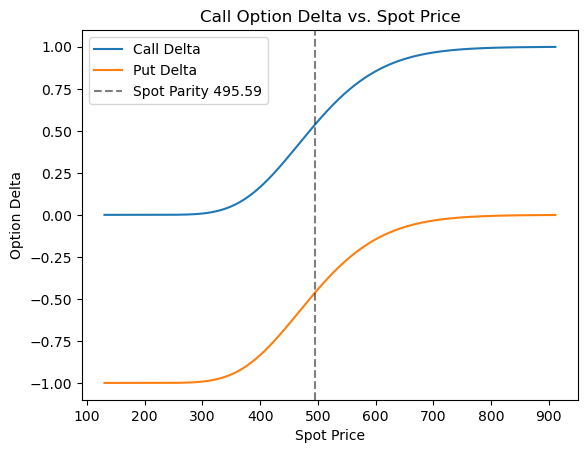

In [6]:
# plot call option deltas for a range of spot prices
call_deltas = [BS(s, E, r, (T-t), sigma).callDelta for s in spots]
put_deltas = [BS(s, E, r, (T-t), sigma).putDelta for s in spots]
plt.plot(spots, call_deltas, label='Call Delta')
plt.plot(spots, put_deltas, label='Put Delta')
plt.axvline(x=spot_parity, color='black', linestyle='--', label=f'Spot Parity {spot_parity:.2f}', alpha=0.5)
plt.xlabel('Spot Price')
plt.ylabel('Option Delta')
plt.title('Call Option Delta vs. Spot Price')
plt.legend()
plt.show()

### Long Call Option Payoff

In [7]:
# define a spot range for plotting
spot_range = 50

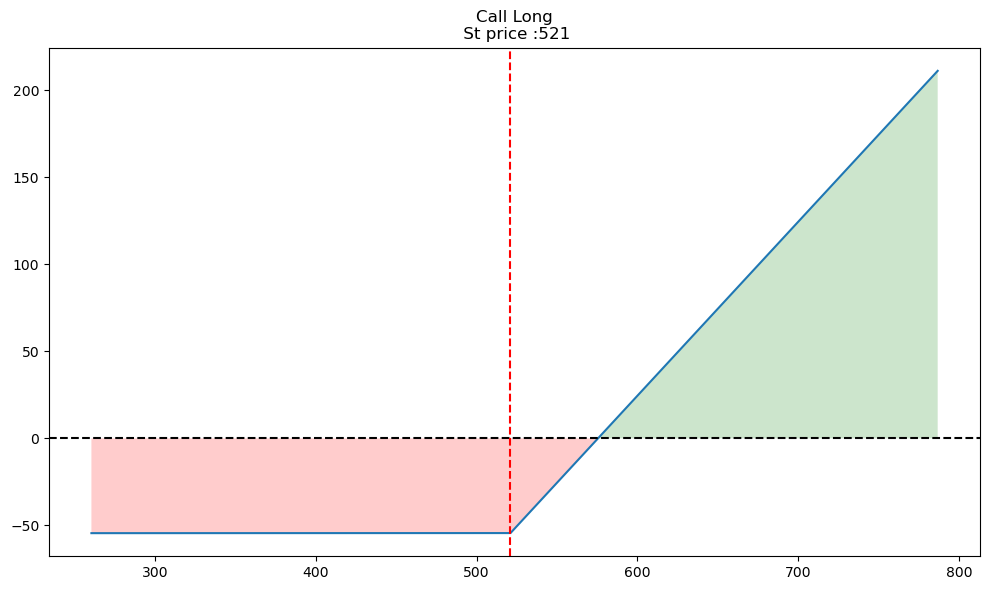

In [8]:
# plot option payoff
op.single_plotter(
    op_type='c',
    spot=option.spot,
    spot_range=spot_range,
    strike=option.strike,
    tr_type='b',
    op_pr=option.callPrice
)

### Long Straddle Payoff

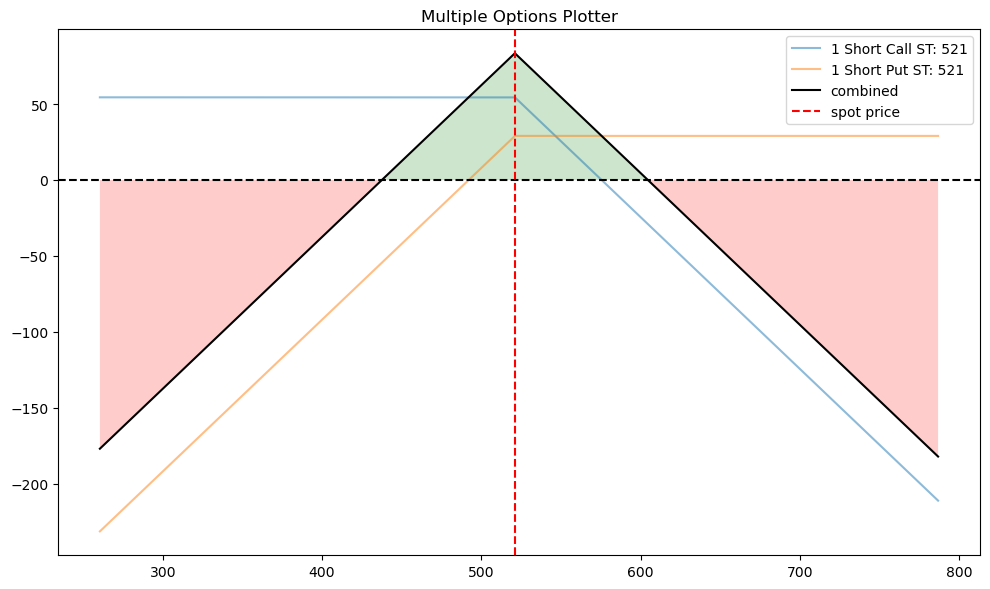

In [9]:
# straddle
op_1 = {'op_type': 'c', 'strike':option.strike, 'tr_type': 's', 'op_pr': option.callPrice}
op_2 = {'op_type': 'p', 'strike':option.strike, 'tr_type': 's', 'op_pr': option.putPrice}
op_list = [op_1, op_2]
op.multi_plotter(spot=option.spot, spot_range=spot_range, op_list=op_list)

# SPY Options

In [10]:
def next_friday():
    today = datetime.today()
    days_until_friday = (4 - today.weekday() + 7) % 7
    days_until_friday = days_until_friday if days_until_friday else 7
    next_friday = today + timedelta(days=days_until_friday)
    return next_friday

In [11]:
ticker = 'SPY'
expiration = str(next_friday().date())

# SPY option chain
ticker_data = yf.Ticker(ticker)
try:
    options = ticker_data.option_chain(expiration)
except:
    expiration = str((next_friday() + timedelta(7)).date())
    options = ticker_data.option_chain(expiration)

year, month, day = int(expiration.split('-')[0]), int(expiration.split('-')[1]), int(expiration.split('-')[2])

### Check price of ATM Call Option vs. BS Model

In [12]:
# March 2024 515 SPY call option price
spot = ticker_data.basic_info['lastPrice']
strike = int(spot)
rate = 0.055
dte = (datetime(year, month, day) - datetime.today()).days/365
vol = 0.12

option_name = options.calls.loc[options.calls['strike'] == strike, 'contractSymbol'].values[0]

spy_opt_bs = BS(spot, strike, rate, dte, vol)
print(f'Option Price of {option_name} with BS Model is {spy_opt_bs.callPrice:0.2f}')

spy_opt_yf = options.calls.loc[options.calls['strike'] == strike, 'lastPrice'].values[0]
print(f'Option Price of {option_name} from Yahoo Finance is {spy_opt_yf:0.2f}')

Option Price of SPY240405C00521000 with BS Model is 4.88
Option Price of SPY240405C00521000 from Yahoo Finance is 4.61


quick note here on possible differences -- we're using the BSE with dte as of today, and the actual option price on yfinance is based on the last trade price which may be earlier, i.e. yesterday or before.

### Plot BS Model vs. Actual Prices

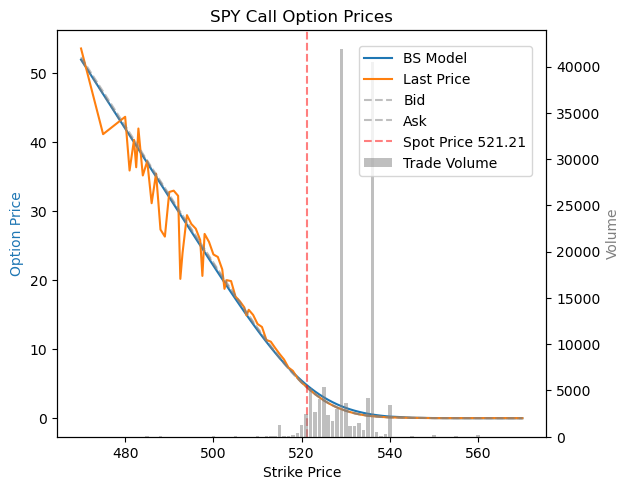

In [13]:
# strikes = options.calls['strike']
lower_bound = 0.9*spot
upper_bound = 1.1*spot
options_temp = options.calls.loc[(options.calls['strike']>=lower_bound) & (options.calls['strike']<=upper_bound)]
strikes = options_temp['strike']
bse_prices = [BS(spot, s, rate, dte, vol).callPrice for s in strikes]
yf_prices = options_temp['lastPrice']
yf_bid = options_temp['bid']
yf_ask = options_temp['ask']
yf_volume = options_temp['volume']

fig, ax1 = plt.subplots()

ax1.plot(strikes, bse_prices, label='BS Model')
ax1.plot(strikes, yf_prices, label='Last Price')
plt.plot(strikes, yf_bid, label='Bid', linestyle='--', alpha=0.5, color='grey')
plt.plot(strikes, yf_ask, label='Ask', linestyle='--', alpha=0.5, color='grey')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Option Price', color='tab:blue')

ax2 = ax1.twinx()
ax2.bar(strikes, yf_volume, alpha=0.5, color='grey', label='Trade Volume')
ax2.set_ylabel('Volume', color='tab:grey')

ax1.axvline(x=spot, color='red', linestyle='--', label=f'Spot Price {spot:.2f}', alpha=0.5)
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.95))
plt.title('SPY Call Option Prices')
plt.show()


quick note again here on possible differences -- where there's low volume, particularly low strike and deep ITM for calls, the last traded price may be stale and not reflective of the actual price today, so bid/ask midpoint is a better metric.

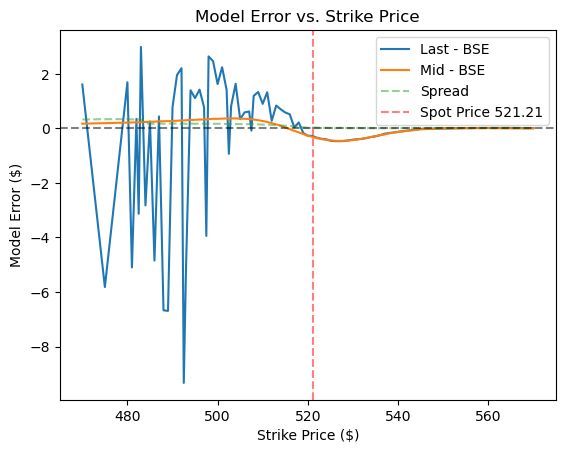

In [14]:
# model errors
price_diff_last = yf_prices - bse_prices
price_diff_mid = (yf_bid + yf_ask)/2 - bse_prices
spread = yf_ask - yf_bid

plt.plot(strikes, price_diff_last, label='Last - BSE')
plt.plot(strikes, price_diff_mid, label='Mid - BSE')
plt.plot(strikes, spread, label='Spread', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=spot, color='red', linestyle='--', label=f'Spot Price {spot:.2f}', alpha=0.5)
plt.xlabel('Strike Price ($)')
plt.ylabel('Model Error ($)')
plt.title('Model Error vs. Strike Price')
plt.legend()
plt.show()

### Greeks vs. Strike

In [15]:
df = options.calls[(options.calls['strike']>=lower_bound) & (options.calls['strike']<=upper_bound)]
df.reset_index(drop=True, inplace=True)

df = pd.DataFrame({'Strike': df['strike'],
                   'Price': df['lastPrice'],
                   'ImpVol': df['impliedVolatility']})

df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):

    opt = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i])

    df['Delta'].iloc[i] = opt.callDelta
    df['Gamma'].iloc[i] = opt.gamma
    df['Vega'].iloc[i] = opt.vega
    df['Theta'].iloc[i] = opt.callTheta


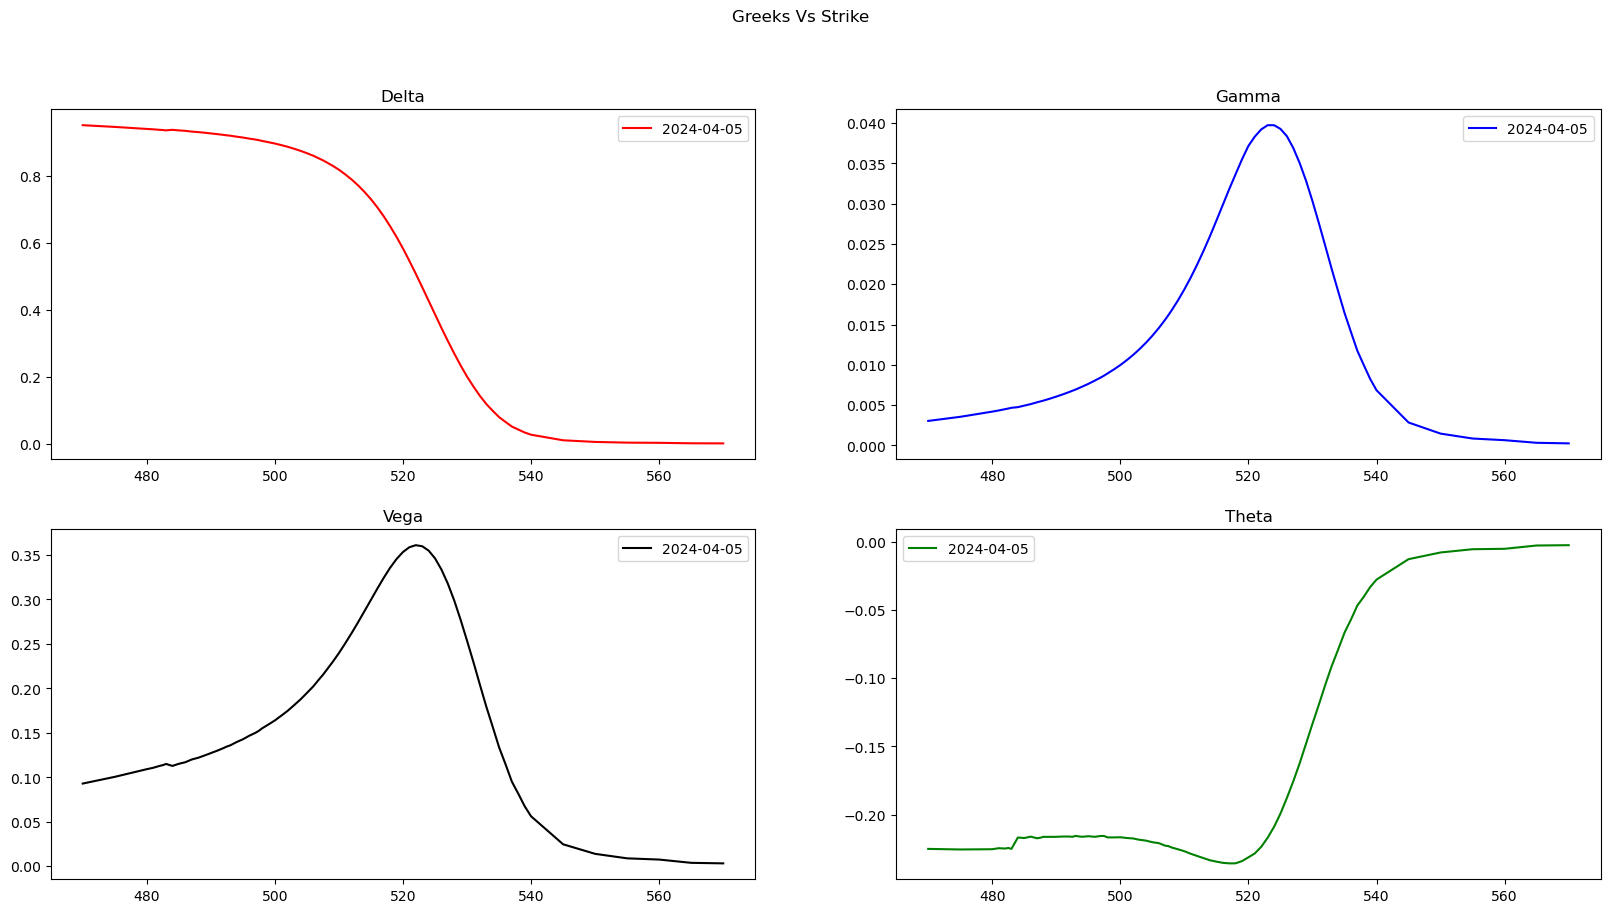

In [16]:
# Plot Greeks vs. Strike for SPY calls
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label=expiration)
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label=expiration)
ax[1,0].plot(df['Strike'], df['Vega'],  color='k', label=expiration)
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label=expiration)

ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()
fig.suptitle('Greeks Vs Strike')

plt.show()